### How to get ARLIE data
In the following, you can find a beginner-friendly guide on how to retrieve ARLIE data.

[The Copernicus Aggregated River and Lake Ice Extent (ARLIE) product](https://land.copernicus.eu/en/products/water-bodies/high-resolution-aggregated-river-and-lake-ice-extent) is a spatially aggregated information on surface water conditions of rivers and lakes. ARLIE information is stored in a geodatabase, enriched every day from the River and Lake Ice extent products (RLIE S1, RLIE S2 and RLIE S1+S2) for the entire EEA38 and the United Kingdom. It provides percent coverage of snow-covered or snow-free ice on lakes and on 10 km river sections described by the EU-HYDRO river and lake network database.<br>
<br>
The ARLIE products are stored in a PostGIS persistent geodatabase. They can be retrieved by using a specific REST API. Users can query ice sheet summary information of river segments and lakes (ARLIE statistics) together with the geometry and caracteristics of the features on which these statistics were estimated. All geometry features are delivered in the ETRS89 LAEA (EPSG:3035) coordinate reference system.<br>
<br>
ARLIE is one of the products of the pan-European High-Resolution Snow & Ice service (HR-S&I), which are provided at high spatial resolution (20 m x 20 m and 60 m x 60 m) from the Sentinel-2 and Sentinel-1 constellations data from September 1, 2016 onwards.<br>
<br>
This notebook contains the following steps:<br>
1) Initial setup
2) Pick your AOI
3) Import your geometry and display it
4) Transform to WKT format
5) Request ARLIE data
6) Display ARLIE data
7) Display EU Hydro data

It is important to note that data requests must adhere to the Well-Known Text (WKT) format.<br>
<br>
This notebook is sligthly modified version of [how-to-get-started notebook](https://github.com/eea/clms-hrsi-arlie-use-case/blob/main/how-to-get-started.ipynb) developed by EEA.


#### **Step 1: Initial setup**
1. First of all, pick your preferred platform for running Jupyter Notebooks<br>
*(For instance, you can opt for the [WekEO platform](https://help.wekeo.eu/en/articles/6337538-what-is-the-wekeo-jupyterhub))*<br>
2. Next, copy this GitHub repository or [the original one](https://github.com/eea/clms-hrsi-arlie-use-case.git) and paste all the included notebooks onto your chosen platform<br>
3. Make sure that you have the [clms_hrsi_arlie_downloader.py](clms_hrsi_arlie_downloader.py) located next to this notebook<br>
*You can see an example of the folder structure below*<br>
<img src="images/folders1.png"/><br>


4. Make sure you have installed all the necessary Python libraries. Additional to some standard Python libraries you will need: 
    - [Folium](https://pypi.org/project/folium/): A library that simplifies the creation of interactive maps using Python and Leaflet.js, allowing for easy visualization of geospatial data., 
    - [Geopandas](https://pypi.org/project/geopandas/): An extension of pandas designed to work with geospatial data, enabling operations like spatial joins and geometric manipulations using familiar DataFrame structures,
    - [Shapely](https://pypi.org/project/shapely/): A library for manipulating and analyzing planar geometric objects, providing tools for creating and working with points, lines, and polygons in a geometric context..<br>
<br>

_Other python libraries that could be quite be handy_:
- *[pandas](https://pandas.pydata.org/)*: A powerful library for data manipulation and analysis, ideal for handling structured data through DataFrames.
  
- *[matplotlib](https://matplotlib.org/)*: A versatile library for creating a wide range of static, animated, and interactive visualizations in Python, focusing on 2D plotting.

- *[pyplot](https://matplotlib.org/stable/api/pyplot_summary.html)*: A module within `matplotlib` that provides a MATLAB-like interface for creating plots easily and interactively.

- *[contextily](https://contextily.readthedocs.io/en/stable/)*: A library used to add basemaps (like satellite imagery or street maps) to geospatial visualizations, especially with `GeoPandas`.


In case you miss any libraries throughout this tutorial, simply install them by running `%pip install {package name}`
See example below:

In [ ]:
# press shift+enter to execute a cell
%pip install folium
%pip install Geopandas
%pip install Shapely

# to uncomment a line, select the line and press ctrl+/ or delete the # and space
%pip install pandas
%pip install matplotlib
%pip install pyplot

# plotly is a library for interactive plots
# %pip install plotly
# %pip install nbformat>=4.2.0



#### **Step 2: Pick your AOI**
To access ARLIE data for your specific AOI, you have two options. You can either upload a predefined geometry (e.g., a shapefile or GeoJSON) or you can draw a custom geometry on a map following the steps below. 

- If you have a [predetermined geometry, jump directly to step 3](#step-3-transform-to-wkt-format). 

- In case you [have a file in WKT format, jump to step 4](#step-4-request-arlie-data).

The geometry is used to request all lake and river polygons from the EU Hydro database within your AOI, which, in turn, is used to retrieve ARLIE data from the PostGIS database.


#### *2.1: Draw a custom geometry using Folium*

When you execute the cell below, an interactive map will appear. You can use this map to draw your Area of Interest (AOI). Follow these steps:

1. *Navigate the Map*: Use the toolbar on the left to zoom in, zoom out, and move around the map.
2. *Draw Your AOI*: Click the drawing tool (polygon) in the toolbar and draw your desired AOI on the map.
3. *Edit Geometry*: If needed, use the toolbar to edit or refine the drawn geometry.
4. *Export the Geometry*: Once you're satisfied with your AOI, click the small 'Export' button on the right side of the toolbar. A window will appear prompting you to save the file.
5. *Save as GeoJSON*: Save the file in GeoJSON format. You can save it either in the same folder as this notebook or anywhere on your computer.
6. *Upload the GeoJSON*: If you saved the file elsewhere, make sure to upload it into the same folder where this notebook is located to ensure the notebook can access it.
<br>
<br>


<img src="images/folium1.png" alt="Drawing" style="width: 800px;"/>

🤫 Note, the geometry should have an appropriate size and complexety, so try with a smaller area if you experience issues later in the workflow.

In [16]:
# Import relevant libraries
import folium
from folium.plugins import Draw

# Initialise an interactive map, get the coordinates from Google Maps for example to center the map
m = folium.Map(location=[64.5, -18], zoom_start=7)

#  Add a function to draw and export your polygon
draw = Draw(export=True, filename='aoi.geojson', position='topleft')
draw.add_to(m)

# Display the map
m

##### *2.2: Import and display you rgeometry*

Once you have saved the GeoJSON file of your AOI in the *data folder*/*, follow the steps below to import and display it. If you already have a GeoJSON file from another source, make sure to place it in the *data folder* and follow the same steps.

Steps:
1. Import the AOI Geometry: The code will read the GeoJSON file from the data folder and convert it into a geospatial format that can be displayed.

    - If you created the GeoJSON in the previous step, it should already be saved in the data folder.
    - If you already have a GeoJSON file from somewhere else, ensure it is placed in the data folder as aoi.geojson or adjust the file path accordingly.

2. Display the AOI: The map will show the outline of your selected area on an interactive map.


In [17]:
# Import relevant libraries
import folium 
import geopandas as gpd
from pathlib import Path # alternative to os.path

# Create the 'data' folder if it doesn't exist using Path
data_dir = Path('data')
data_dir.mkdir(exist_ok=True)

# Set the path to your AOI using Path
aoi_path = data_dir / 'aoi.geojson'

# Read the AOI as a GeoDataFrame
gdf = gpd.read_file(aoi_path)


# Retrieve the center points of the AOI for map centering 
aoiX = gdf["geometry"].centroid.x
aoiY = gdf["geometry"].centroid.y


# Display the AOI on a map
m = folium.Map(
    location=[aoiY[0], aoiX[0]],
    tiles='OpenStreetMap',
    zoom_start=7,
    min_zoom=1,
    max_zoom=15,
    control_scale=True
)

# Add the AOI to the map
folium.GeoJson(str(aoi_path), name="AOI", style_function=lambda x: {
    'fillOpacity': 0.1,
    'color': 'Crimson'
}).add_to(m)

# Show the map
m

C:\Users\michaela.hrabalikova\AppData\Local\Temp\ipykernel_26760\1576926829.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  aoiX = gdf["geometry"].centroid.x
C:\Users\michaela.hrabalikova\AppData\Local\Temp\ipykernel_26760\1576926829.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  aoiY = gdf["geometry"].centroid.y


#### Step 3: Transform to WKT format
Transform your AOI from the Geojson to WKT format using Shapely. In case you uploaded a shapefile, simply use this as input.

In [18]:
# Import relevant libraries
import json
from shapely.geometry import shape

# Set the path to your AOI
aoi = "data/aoi.geojson"

# Use Shapely to transform to WKT format and save it
with open(Path(aoi)) as fin, open(Path(aoi).with_suffix(".wkt"), "w") as fout:
    features = json.load(fin)["features"]
    for feature in features:
        geo = shape(feature["geometry"])
        wkt = geo.wkt
        fout.write(wkt + "\n")

In [19]:
# A WKT (Well-Known Text) is a scheme for writing a geometry into a standard text string, as you can see below
wkt

'POLYGON ((-19.659868 63.984371, -19.659868 64.450273, -18.15734 64.450273, -18.15734 63.984371, -19.659868 63.984371))'

#### Step 4: Request ARLIE data
The retrieval of the ARLIE data can take a while, depending on the size and complexety of your AOI. In the end, you should see a message informing on where the output has been saved and how many ARLIE records have been found.

In [20]:
# Import the API to download ARLIE data
from clms_hrsi_arlie_downloader import download_arlie_products

# Set the following variables to retrieve ARLIE data:
geometryWkt = wkt               # The WKT you have generated above, or simply copy+paste a geometry directly (eg. 'POLYGON ((9.667968999999999 52.48278, 10.722656 51.289406, 6.855469 49.496675, 10.283203 47.457809, 15.205078 48.922499, 14.238281 51.344339, 9.667968999999999 52.48278))')
outputDir = "./output"          # Your preferred output folder
startDate = '2017-01-01'        # Start date for ARLIE data
completionDate = '2024-09-01'   # End date for ARLIE data
cloudCoverageMax = 100          # Maximum cloud cover to consider
requestGeometries = True        # True returns polygons from EU Hydro, False only returns the ARLIE data
returnMode = 'csv_and_variable' # choose between "csv", "csv_and_variable", "variable"

geom, arlie = download_arlie_products(
    returnMode, 
    outputDir=outputDir, 
    startDate=startDate, 
    completionDate=completionDate, 
    geometryWkt=geometryWkt, 
    cloudCoverageMax=cloudCoverageMax, 
    requestGeometries=requestGeometries)

Executing request for geometries: https://cryo.land.copernicus.eu/arlie/get_geometries?geometrywkt=POLYGON+((-19.659868+63.984371%2C+-19.659868+64.450273%2C+-18.15734+64.450273%2C+-18.15734+63.984371%2C+-19.659868+63.984371))&getonlyids=True
Executing request for geometries: https://cryo.land.copernicus.eu/arlie/get_geometries?geometrywkt=POLYGON+((-19.659868+63.984371%2C+-19.659868+64.450273%2C+-18.15734+64.450273%2C+-18.15734+63.984371%2C+-19.659868+63.984371))
Writing geometries in d:\Git\Copernicus\Land\clms-hrsi-arlie_demo-iceland\output\geometries.csv
Executing request for ARLIE: https://cryo.land.copernicus.eu/arlie/get_arlie?geometrywkt=POLYGON+((-19.659868+63.984371%2C+-19.659868+64.450273%2C+-18.15734+64.450273%2C+-18.15734+63.984371%2C+-19.659868+63.984371))&cloudcoveragemax=100&startdate=2017-01-01&completiondate=2024-09-01
Done
Writing ARLIE in d:\Git\Copernicus\Land\clms-hrsi-arlie_demo-iceland\output\arlie.csv
Found 318450 ARLIE products.
Writing metadata link into d:\Gi

#### Step 6: Display ARLIE data
We now retrieved the ARLIE data in a csv format and saved it to the folder <code style="background:yellow;color:black">output</code>.
The data should look similar to this when opening as a list:
> [[1, 46493, '2019-01-01T17:16:05', 27, 56, 0, 0, 17 ,1 ,'Sentinel-1 Sentinel-2'],
 [2, 46493, '2019-01-02T17:07:26', 62, 23, 0, 0, 15, 1, 'Sentinel-1 Sentinel-2']], [3, 46493, '2019-01-03T16:59:52', 51, 35, 0, 0, ...

Pass the statistics into a Pandas DataFrame to easier explore and organise the data by running the cell below.

#### *6.1: Reading and Cleaning data*

In [21]:
# Import relevant libraries
import pandas as pd
from datetime import datetime
#import os

# Parse the orignial ARLIE date format to something more readable
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S')

# Read ARLIE data from CSV file into a DataFrame
arlie = pd.read_csv('output/arlie.csv', parse_dates=['datetime'], delimiter=";")

# Extract both month and year from the 'datetime' column
arlie["month"] = arlie["datetime"].dt.month
arlie["year"] = arlie["datetime"].dt.year

# Display the first 5 rows of the DataFrame
#arlie.head()
arlie

,id,river_km_id,datetime,water_perc,ice_perc,other_perc,cloud_perc,nd_perc,qc,source,month,year
0,1,112902,2017-01-06 18:51:04,78,0,0,0,22,2,Sentinel-1,1,2017
1,2,112902,2017-01-11 07:41:53,82,4,0,0,14,2,Sentinel-1,1,2017
2,3,112902,2017-01-11 18:59:17,78,0,0,0,22,2,Sentinel-1,1,2017
3,4,112902,2017-01-18 18:51:04,78,0,0,0,22,2,Sentinel-1,1,2017
4,5,112902,2017-01-23 07:41:53,85,0,0,0,15,2,Sentinel-1,1,2017
...,...,...,...,...,...,...,...,...,...,...,...,...
318445,318446,119165,2024-08-14 18:59:51,49,39,0,0,12,0,Sentinel-1 Sentinel-2,8,2024
318446,318447,119165,2024-08-16 18:43:32,37,45,1,0,17,0,Sentinel-1 Sentinel-2,8,2024
318447,318448,119165,2024-08-21 18:51:44,49,41,0,0,10,0,Sentinel-1,8,2024
318448,318449,119165,2024-08-26 18:59:51,48,30,3,0,19,0,Sentinel-1 Sentinel-2,8,2024


The output should now look similar to the table above, with the following columns:<p>

>**id** = unique identifcation number for each ARLIE record <br>
**river_km_id** = identification number for the lake or river section polygon from the EU Hydro database<br>
**datetime** = date and time of ARLIE record<br>
**water_perc** = amount of water per waterbody in %<br>
**ice_perc** = amount of ice or snow cover per waterbody in %<br>
**other_perc** = amount of other features per waterbody in %<br>
**cloud_perc** = cloud cover per waterbody in %<br>
**nd_perc** = no data pixels per waterbody %<br>
**source** = satellite data used to derive ARLIE record<br>
**qc** = quality control value with the following quality levels:
>> high quality: 0.5 > ARLIE_confidence ≥ 0<br>
>> medium quality: 1.5 > ARLIE_confidence ≥ 0.5<br>
>> low quality: 2.5 > ARLIE_confidence ≥ 1.5<br>
>> minimal quality: 3.0 ≥ ARLIE_confidence ≥ 2.5<br>
    
To organise the data, you can sort it by date and filter it for the highest quality level. Do do this, run the cell below.

In [22]:
# Sort records by datetime
arlie = arlie.sort_values(by="datetime", ascending=True)

# Only get records with high confidence (i.e. QC flag = 0)
arlie = arlie.where(arlie.qc == 0).dropna()
display(arlie)

,id,river_km_id,datetime,water_perc,ice_perc,other_perc,cloud_perc,nd_perc,qc,source,month,year
300981,300982.0,119083.0,2017-01-06 07:33:43,91.0,4.0,0.0,0.0,5.0,0.0,Sentinel-1,1.0,2017.0
311425,311426.0,119156.0,2017-01-06 07:33:43,28.0,57.0,0.0,0.0,15.0,0.0,Sentinel-1,1.0,2017.0
299427,299428.0,119082.0,2017-01-06 07:33:43,86.0,8.0,0.0,0.0,6.0,0.0,Sentinel-1,1.0,2017.0
303942,303943.0,119109.0,2017-01-06 07:33:43,50.0,37.0,0.0,0.0,13.0,0.0,Sentinel-1,1.0,2017.0
299428,299429.0,119082.0,2017-01-06 18:51:04,81.0,9.0,0.0,0.0,10.0,0.0,Sentinel-1,1.0,2017.0
...,...,...,...,...,...,...,...,...,...,...,...,...
314315,314316.0,119157.0,2024-08-28 18:43:32,65.0,19.0,0.0,0.0,16.0,0.0,Sentinel-1 Sentinel-2,8.0,2024.0
315779,315780.0,119158.0,2024-08-28 18:43:32,10.0,82.0,0.0,0.0,8.0,0.0,Sentinel-1 Sentinel-2,8.0,2024.0
317113,317114.0,119163.0,2024-08-28 18:43:32,3.0,79.0,0.0,0.0,18.0,0.0,Sentinel-1 Sentinel-2,8.0,2024.0
305345,305346.0,119109.0,2024-08-28 18:43:32,70.0,15.0,0.0,0.0,15.0,0.0,Sentinel-1 Sentinel-2,8.0,2024.0


#### *6.2: Calculate simple statistics and plot data*

In [23]:
# Calculate simple statistics like mean. If you like, try to change .mean() to .max() or .median()
print('Monthly mean ice cover in 2023:')
arlie[arlie['year'] == 2023]['ice_perc'].groupby(arlie['month']).mean()

Monthly mean ice cover in 2023:


month
1.0     49.373626
2.0     27.387670
3.0     44.192900
4.0     25.415800
5.0     19.888506
6.0      2.050847
7.0      1.709547
8.0      1.153523
9.0      2.256281
10.0     5.089708
11.0    16.469880
12.0    38.805556
Name: ice_perc, dtype: float64

In [28]:
# Import relevant libraries
import matplotlib
from matplotlib import pyplot as plt
import calendar
from matplotlib.cm import get_cmap
import pandas as pd
import geopandas as gpd
from shapely.wkt import loads


In [29]:
# Read EU Hydro geometries from CSV file
geometries = pd.read_csv('output/geometries.csv', delimiter=";")
geometries['geometry'] = geometries['geometry'].apply(loads)
# Add the geometries to a GeoDataFrame
geometries = gpd.GeoDataFrame(geometries, geometry='geometry', crs='EPSG:3035')

# Select the ten biggest lakes based on the column "area"
biggest_lakes = geometries.nlargest(5, "area")
biggest_lakes_id = biggest_lakes.id.values
biggest_lakes_names = biggest_lakes['object_nam'].values  # Assuming the column 'name' contains lake names
print("Those are the five biggest lakes in our AOI:")
print(biggest_lakes)

Those are the five biggest lakes in our AOI:
         id                                           geometry basin_name  \
68   118792  MULTIPOLYGON (((2953134.729 4856545.843, 29531...    Iceland   
147  118797  MULTIPOLYGON (((2987799.115 4843828.399, 29878...    Iceland   
192  113093  MULTIPOLYGON (((2941628.018 4870892.376, 29416...    Iceland   
210  113148  MULTIPOLYGON (((2945010.212 4851512.076, 29449...    Iceland   
95   118796  MULTIPOLYGON (((2964518.44 4847615.656, 296451...    Iceland   

    eu_hydro_id      object_nam         area  river_km  
68          NaN       þórisvatn  86260012.69       NaN  
147         NaN       Langisjór  24834250.38       NaN  
192         NaN  Sultartangalón  20414889.99       NaN  
210         NaN        Krókslón  12180188.39       NaN  
95   IW23008004             UNK   9024379.34       NaN  


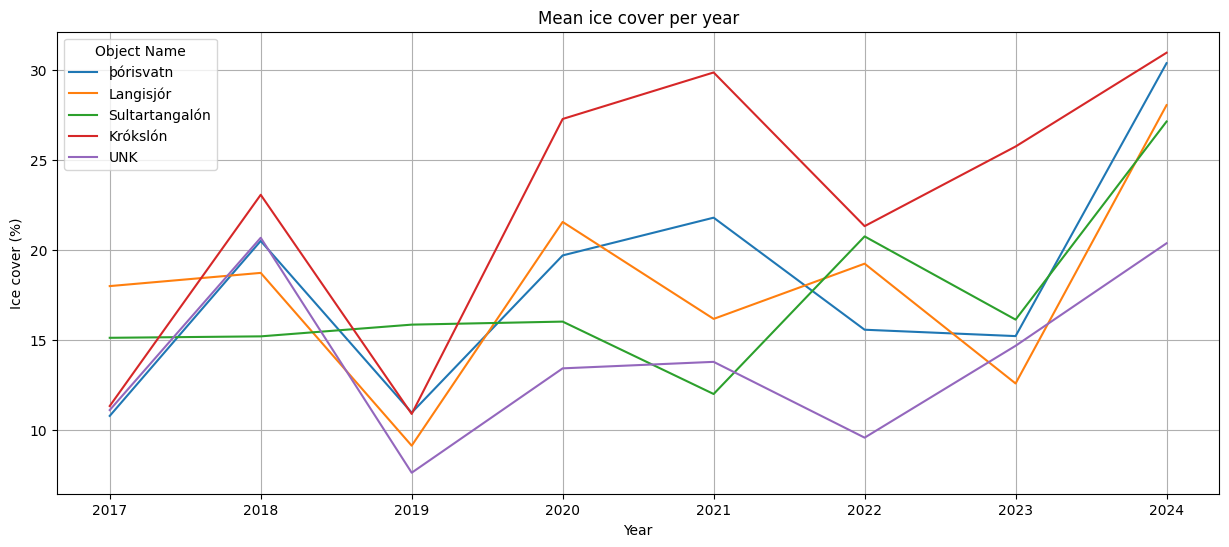

In [30]:
# Plot the mean ice cover for those lakes
plt.figure(figsize=(15, 6))

# Loop over both lake IDs and lake names
for river_km_id, lake_name in zip(biggest_lakes_id, biggest_lakes_names):
    annual_mean = arlie[arlie['river_km_id'] == river_km_id].groupby('year')['ice_perc'].mean()
    plt.plot(annual_mean.index, annual_mean.values, linestyle='-', label=f'{lake_name}')  # Use lake name in the legend

plt.title('Mean ice cover per year')
plt.xlabel('Year')
plt.ylabel('Ice cover (%)')
plt.grid(True)
plt.legend(title="Object Name")
plt.show()

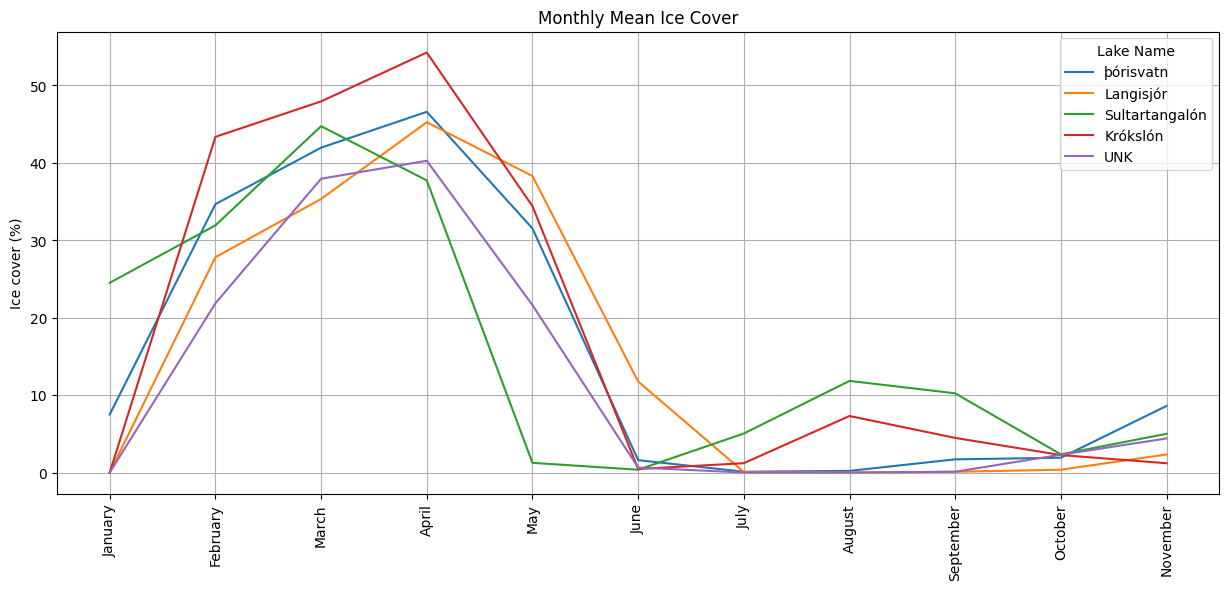

In [31]:
# Plot the seasonal ice cover for those ten lakes
plt.figure(figsize=(15, 6))

# Loop over both lake IDs and lake names
for river_km_id, lake_name in zip(biggest_lakes_id, biggest_lakes_names):
    # Group by 'month' and calculate the mean ice percentage for each month
    monthly_mean = arlie[arlie['river_km_id'] == river_km_id].groupby('month')['ice_perc'].mean()
    
    # Just be sure that the index is an integer (in case of float or other data types)
    monthly_mean.index = monthly_mean.index.astype(int)

    # Sort the months in ascending order (1 = January, 12 = December)
    monthly_mean = monthly_mean.sort_index()
    
    # Convert month numbers to month names
    month_names = [calendar.month_name[month] for month in monthly_mean.index]
    
    # Plot the data
    plt.plot(month_names, monthly_mean.values, linestyle='-', label=f'{lake_name}')  # Use lake name in the legend

plt.title('Monthly Mean Ice Cover')
plt.ylabel('Ice cover (%)')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend(title='Lake Name', loc='upper right')

#### 6.3: Let's do more

Examine annual differences in lake ice extend

Lets dig a bit deeper into the data and look at the annual differences for all lakes within the AOI


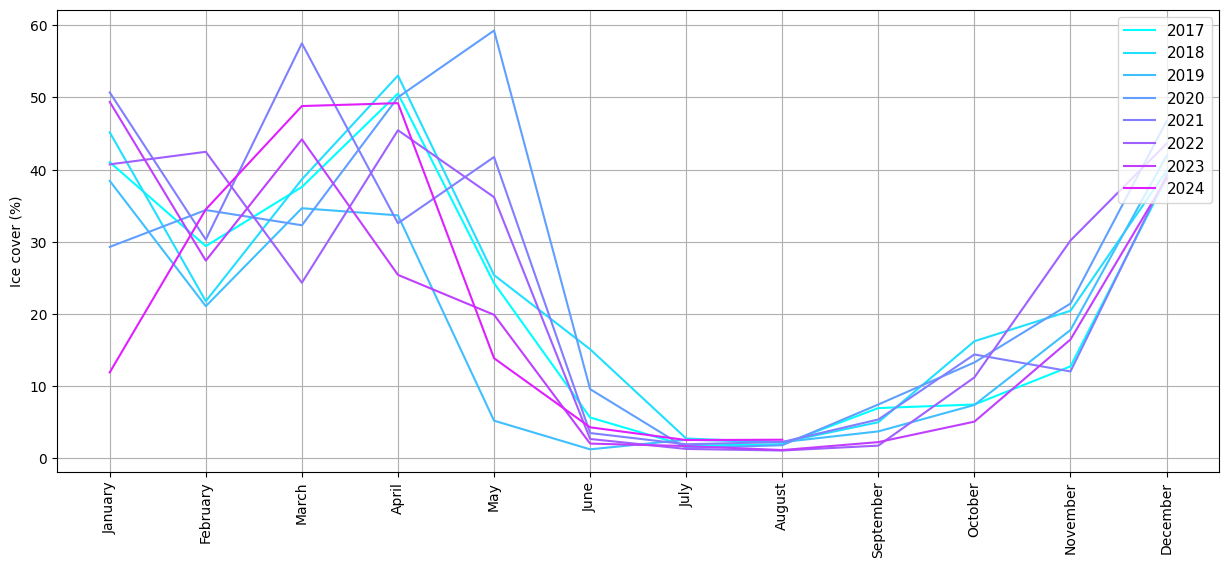

In [32]:
# you can try to change the .mean() to .max() or .median() to display different statistics

# List of years to loop through
years = [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

plt.figure(figsize=(15, 6))

# Loop through each year and plot its monthly average
for i, year in enumerate(years):
    # Group by 'month' and calculate the mean ice percentage for each year
    annual_average = arlie[arlie['year'] == year]['ice_perc'].groupby(arlie['month']).mean()
    
    # Ensure the index (month) is an integer
    annual_average.index = annual_average.index.astype(int)
    
    # Convert the month numbers to month names
    month_names = [calendar.month_name[month] for month in annual_average.index]
    
    # Use a colormap to assign colors to each year
    line_color = matplotlib.colormaps['cool'](i / len(years))
    
    # Plot the data
    plt.plot(month_names, annual_average.values, linestyle='-', label=f'{year}', color=line_color)

# Customize the plot
plt.xticks(rotation=90)
plt.ylabel('Ice cover (%)')
plt.grid(True)
plt.legend(loc='upper right', fontsize=11, title_fontsize=12)
plt.show()

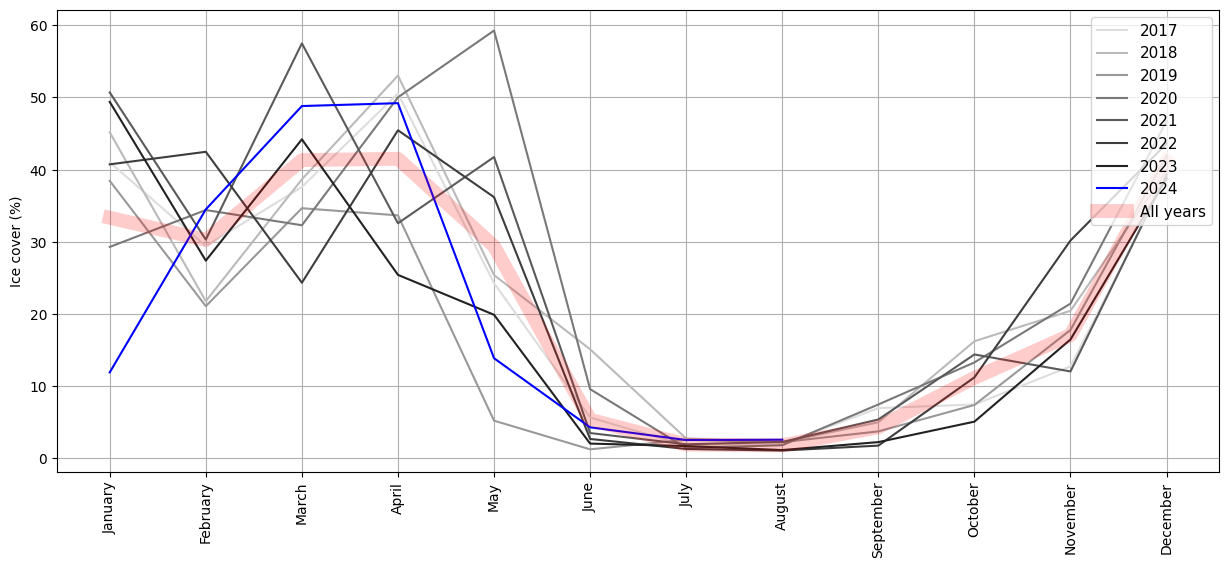

In [33]:
# We can also compare a mean of all years against individual years. To highlight a specific year, just change the year in line 22 below.
plt.figure(figsize=(15, 6))

# Grayscale palette for non-highlighted years
grayscale_palette = ['#dddddd', '#bababa', '#999999', '#797979', '#5a5a5a', '#3d3d3d', '#222222']

# Calculate the average of all years
average_all_years = arlie['ice_perc'].groupby(arlie['month']).mean()

# Loop through each year and plot the annual average
for i, year in enumerate(years):
    # Group by 'month' and calculate the mean ice percentage for each year
    annual_average = arlie[arlie['year'] == year]['ice_perc'].groupby(arlie['month']).mean()

    # Ensure the index (month) is an integer
    annual_average.index = annual_average.index.astype(int)
    
    # Convert the month numbers to month names
    month_names = [calendar.month_name[month] for month in annual_average.index]
    
    # Set the color to blue for the selected year, and grayscale for other years
    line_color = 'blue' if year == 2024 else grayscale_palette[i % len(grayscale_palette)]
    
    # Plot the annual data for each year
    plt.plot(month_names, annual_average.values, linestyle='-', label=f'{year}', color=line_color)

# Plot the average of all years as a red line
average_all_years.index = average_all_years.index.astype(int)
plt.plot(
    [calendar.month_name[month] for month in average_all_years.index],
    average_all_years.values,
    linestyle='-',
    color='Red',
    label='All years',
    linewidth=10,
    alpha=0.2
)

# Customize the plot
plt.xticks(rotation=90)
plt.ylabel('Ice cover (%)')
plt.grid(True)
plt.legend(loc='upper right', fontsize=11, title_fontsize=12)
plt.show()

Let's try different library for plotting

In [ ]:
# plotly is a library for interactive plots
# %pip install plotly
# %pip install nbformat>=4.2.0

In [37]:
import plotly.graph_objs as go
import calendar

# 'arlie' DataFrame is already available from previous cells
years = arlie['year'].unique()

# Therefore we have to calculate the mean ice cover for all years
average_all_years = arlie['ice_perc'].groupby(arlie['month']).mean()

# The month index is an integer, so as usual, be sure about it
average_all_years.index = average_all_years.index.astype(int)

# Create a list to store Plotly traces
traces = []

# Grayscale palette for other years
grayscale_palette = ['#dddddd', '#bababa', '#999999', '#797979', '#5a5a5a', '#3d3d3d', '#222222']

# Plot individual years
for i, year in enumerate(years):
    annual_average = arlie[arlie['year'] == year]['ice_perc'].groupby(arlie['month']).mean()
    
    # the month index must be an integer, so be sure about it
    annual_average.index = annual_average.index.astype(int)
    
    # convert the month numbers to month names
    month_names = [calendar.month_name[month] for month in annual_average.index]
    
    # Set the color: blue for 2023, grayscale for other years
    line_color = 'blue' if year == 2023 else grayscale_palette[i % len(grayscale_palette)]
    
    # Create a Plotly trace for each year
    traces.append(go.Scatter(
        x=month_names,
        y=annual_average.values,
        mode='lines',
        name=str(int(year)),
        line=dict(color=line_color),
        hoverinfo='x+y'
    ))

# Add the average of all years as a red line
traces.append(go.Scatter(
    x=[calendar.month_name[month] for month in average_all_years.index],
    y=average_all_years.values,
    mode='lines',
    name='All years',
    line=dict(color='red', width=6, dash='dot'),
    opacity=0.5,
    hoverinfo='x+y'
))

# Create the layout
layout = go.Layout(
    title="Monthly Mean Ice Cover: All Years vs Individual Years",
    xaxis=dict(title='Month', tickangle=90),
    yaxis=dict(title='Ice cover (%)'),
    hovermode='x unified',  # This makes hover display all lines at once
    showlegend=True,
    legend=dict(title="Years", x=1, y=1),
    autosize=True # with this we make the plot responsive to the screen size
)

# Create the figure
fig = go.Figure(data=traces, layout=layout)

# Show the figure
fig.show()


### Step 7: Display EU Hydro data

Along with the ARLIE statistics, we retrieved EU Hydro data in csv format. Those contain vector polygon data with information about the lake/river ID, lake/river basin name, EU Hydro ID, object name, area, and river kilometre from the mouth (only for rivers which are split into 10 km long sections). Note, that we only recieve the individual EU Hydro ID numbers and no river/lake names. Read more about the full EU Hydro dataset and retrieve the river/lake names [here](#https://www.eea.europa.eu/en/datahub/datahubitem-view/2e782ca5-c7b2-4b48-8928-03031b642176).

By passing the csv file into a Pandas GeoDataFrame we can display the geometries on a folium map. Run the cells below to see how this works.

In [35]:
from shapely.wkt import loads

# Read the geometries from csv file
geometries = pd.read_csv('output/geometries.csv', delimiter=";", encoding='utf-8')

# Convert the WKT geometry strings to Shapely geometry objects
geometries['geometry'] = geometries['geometry'].apply(loads)

# Create a GeoDataFrame. As the ARLIE data comes in the LAEA European projection, we use the crs EPSG:3035
EUhydro_gdf = gpd.GeoDataFrame(geometries, geometry='geometry', crs='EPSG:3035')

# Select the five biggest lakes based on the column "area"
biggest_lakes = EUhydro_gdf.nlargest(5, "area")
biggest_lakes.head()

,id,geometry,basin_name,eu_hydro_id,object_nam,area,river_km
68,118792,"MULTIPOLYGON (((2953134.729 4856545.843, 29531...",Iceland,NaN,þórisvatn,86260012.69,NaN
147,118797,"MULTIPOLYGON (((2987799.115 4843828.399, 29878...",Iceland,NaN,Langisjór,24834250.38,NaN
192,113093,"MULTIPOLYGON (((2941628.018 4870892.376, 29416...",Iceland,NaN,Sultartangalón,20414889.99,NaN
210,113148,"MULTIPOLYGON (((2945010.212 4851512.076, 29449...",Iceland,NaN,Krókslón,12180188.39,NaN
95,118796,"MULTIPOLYGON (((2964518.44 4847615.656, 296451...",Iceland,IW23008004,UNK,9024379.34,NaN


In [36]:
# Set the path to your AOI in geojson format and read it as GeoDataFrame
aoi = "data/aoi.geojson"
aoi_gdf = gpd.read_file(aoi)

# Retrieve the center points of the AOI to display it later
aoiX = aoi_gdf["geometry"].centroid.x
aoiY = aoi_gdf["geometry"].centroid.y

# Create an empty map
m = folium.Map(
    location=[aoiY[0],aoiX[0]],
    tiles='OpenStreetMap',
    zoom_start=7,
    min_zoom=1,
    max_zoom=15,
    control_scale=True
)

# Add Esri World Imagery as another basemap layer
folium.TileLayer('Esri.WorldImagery').add_to(m)


# Add labels to the EU Hydro data (for example, if there is a 'name' column)
tooltip = folium.GeoJsonTooltip(fields=['object_nam'], aliases=['Lake/River:'], sticky=True)

# Highlight the five biggest lakes with a different style (e.g., thicker border, different color)
folium.GeoJson(
    biggest_lakes, 
    name="Biggest Lakes", 
    style_function=lambda x: {'color': 'Yellow', 'weight': 5, 'fillOpacity': 0.3}
).add_to(m)

# Add the EU Hydro data with tooltips
folium.GeoJson(
    EUhydro_gdf, 
    name="EU Hydro rivers & Lakes", 
    style_function=lambda x: {'color': 'RoyalBlue'},
    tooltip=tooltip
).add_to(m)

# Add the EU Hydro data and your AOI to an interactive map and display it
folium.GeoJson(
    aoi, 
    name="AOI", 
    style_function=lambda x: {'fillOpacity': 0,'color': 'Crimson'}
).add_to(m)

folium.LayerControl().add_to(m)

# Display the map
m

C:\Users\michaela.hrabalikova\AppData\Local\Temp\ipykernel_26760\2679401779.py:6: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\michaela.hrabalikova\AppData\Local\Temp\ipykernel_26760\2679401779.py:7: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




Awesome! 🥳 You now requested ARLIE data and the assoiciated EU Hydro polygons for your AOI! We will continue in the next notebook to show you how to manipulate data. 